Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Episode:     1		score:  -77.52		average:  -77.52
Episode:     2		score:    4.45		average:  -36.53
Episode:     3		score: -130.33		average:  -67.80
Episode:     4		score: -350.51		average: -138.48
Episode:     5		score:  -93.71		average: -129.52
Episode:     6		score: -107.07		average: -125.78
Episode:     7		score: -305.42		average: -151.44
Episode:     8		score: -121.97		average: -147.76
Episode:     9		score:  -81.63		average: -140.41
Episode:    10		score:  -95.31		average: -135.90
Episode:    11		score:  -30.39		average: -126.31
Episode:    12		score: -301.49		average: -140.91
Episode:    13		score: -171.84		average: -143.28
Episode:    14		score: -177.77		average: -145.75
Episode:    15		score: -103.25		average: -142.91
Episode:    16		score:  -50.21		average: -137.12
Episode:    17		score:  -89.13		average: -134.30
Episode:    18		score:  -58.41		average: -130.08
Episode:    19		score: -137.02		avera

Episode:   164		score:  -18.62		average: -108.94
Episode:   165		score:  -46.36		average: -108.00
Episode:   166		score:  -65.54		average: -108.57
Episode:   167		score:  -37.46		average: -108.13
Episode:   168		score:  -40.86		average: -107.33
Episode:   169		score:  -40.79		average: -105.84
Episode:   170		score: -149.76		average: -106.41
Episode:   171		score:  -39.90		average: -106.80
Episode:   172		score:  -64.71		average: -106.02
Episode:   173		score:  -58.60		average: -104.64
Episode:   174		score:  -60.71		average: -102.15
Episode:   175		score:  -63.76		average: -100.47
Episode:   176		score:  -79.54		average:  -99.80
Episode:   177		score:  -93.73		average:  -99.17
Episode:   178		score:   -6.06		average:  -97.83
Episode:   179		score: -225.59		average:  -98.60
Episode:   180		score:  -61.39		average:  -98.02
Episode:   181		score: -129.34		average:  -97.91
Episode:   182		score:  -45.62		average:  -97.10
Episode:   183		score:  -54.52		average:  -96.93
Episode:   184		scor

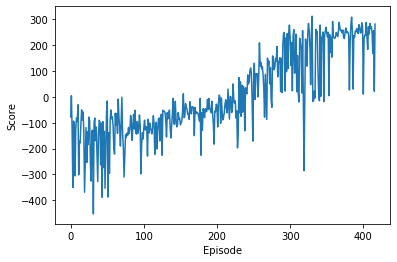

In [1]:
import os

import random
import gym
import pylab
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt

#tf.config.experimental_run_functions_eagerly(True)
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import copy

NUM_ENVS = 8
EPISODES = 10000 # Number of times the enviroment is ran
LOSS_CLIPPING = 0.2 # Approximated values stated in the original paper
ENTROPY_LOSS = 0 # Epochs to train the network (recommended between 3 and 30)
LR = 0.0003 # Learning rate 
NUM_ACTIONS = 4 # Number of possible action in the environment
NUM_STATES = 8 # Number of possible states in the exvironment
EPOCHS = 10 # Epochs to train the network (recommended between 3 and 30)
BATCH_SIZE = 64 # Batch size for the neural nets
BUFFER_SIZE = 512 # Buffer of experiences
SHUFFLE = True # Whether to shuffle data or not while training
OPTIMIZER = Adam # Optimizer for both actor and critic
GAMMA = 0.99 # Used for the estimated reward
LAMBDA = 0.95 # Used in the original paper un the GAE
NORMALIZE = True # Whether to normalize GAE or not


# Create the actor used to select the action given an state
class Actor_Model:
    def __init__(self):
        X_input = Input(NUM_STATES)

        X = Dense(128, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X_input)
        X = Dense(128, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X)
        X = Dense(128, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X)
        
        # Softmax as there are different probabilities depending on the action
        output = Dense(NUM_ACTIONS, activation="softmax")(X)
        
        # Compile the model with the custom loss
        self.model = Model(inputs = X_input, outputs = output)
        self.model.compile(loss=self.ppo_loss, optimizer=OPTIMIZER(lr=LR))

    # Custom loss functions for the PPO
    def ppo_loss(self, y_true, y_pred):
        # Unpack the elements given in the true label
        advantages, true_label, actions = y_true[:, :1], y_true[:, 1:1+NUM_ACTIONS], y_true[:, 1+NUM_ACTIONS:]
        
        prob = actions * y_pred
        old_prob = actions * true_label 

        ratio = K.exp(K.log(prob + 1e-10) - K.log(old_prob + 1e-10))
        
        p1 = ratio * advantages
        p2 = K.clip(ratio, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantages

        actor_loss = -K.mean(K.minimum(p1, p2))

        entropy = -(y_pred * K.log(y_pred + 1e-10))
        entropy = ENTROPY_LOSS * K.mean(entropy)
        
        total_loss = actor_loss - entropy

        return total_loss

# Create the critic which will criticise how the actor is performing    
class Critic_Model:
    def __init__(self):
        X_input = Input(NUM_STATES)

        X = Dense(128, activation="relu", kernel_initializer='he_uniform')(X_input)
        X = Dense(128, activation="relu", kernel_initializer='he_uniform')(X)
        X = Dense(128, activation="relu", kernel_initializer='he_uniform')(X)
        
        # Linear output to know how good the action is
        value = Dense(1)(X)
        
        # Compile it with mse loss and gradient descent
        self.model = Model(inputs=X_input, outputs = value)
        self.model.compile(loss='mse', optimizer=OPTIMIZER(lr=LR))

# Combine both Actor and Critic to create the agent
class PPOAgent:
    def __init__(self, env_name):
        # Environment parameters
        self.env_name = env_name       
        self.env = gym.vector.make("LunarLander-v2", num_envs=NUM_ENVS)
        self.episode = 0 # used to track current number episoded since start
        self.max_average = 0 # record max average reached
        
        # Used to plot a grapgh of the train process
        self.scores_, self.average_ = [], []

        # Create Actor-Critic network models
        self.Actor = Actor_Model()
        self.Critic = Critic_Model()
    
        # Names for the models
        self.Actor_name = f"{self.env_name}_PPO_Actor.h5"
        self.Critic_name = f"{self.env_name}_PPO_Critic.h5"

    # Get the action given the current state    
    def act(self, state):
        # Use the network to predict the next action to take, using the model
        prediction = self.Actor.model.predict(state)

        # Probability based to choose the action
        action = [np.random.choice(NUM_ACTIONS, p=pred) for pred in prediction]

        action_onehot = np.zeros([NUM_ENVS, NUM_ACTIONS])
        for ii in range(NUM_ENVS):
            action_onehot[ii][action[ii]] = 1

        return action, action_onehot, prediction
        
    # Get the action given the current state    
    def act1(self, state):
        # Use the network to predict the next action to take, using the model
        prediction = self.Actor.model.predict(state)[0]
        
        # Probability based to choose the action
        action = np.random.choice(NUM_ACTIONS, p=prediction)
        action_onehot = np.zeros([NUM_ACTIONS])
        action_onehot[action] = 1
        return action, action_onehot, prediction

    # Generalized Advantage Estimation implemented in the original paper
    def get_gaes(self, rewards, dones, values, next_values):
        # Dones are used to track when is the final step of an episode, so next values are no applied
        deltas = [r + GAMMA * (1 - d) * nv - v for r, d, nv, v in zip(rewards, dones, next_values, values)]
        
        # Convert list to array as .mean() and .std() are used later
        deltas = np.stack(deltas)
        gaes = copy.deepcopy(deltas)
        
        for t in reversed(range(len(deltas) - 1)):
            gaes[t] = gaes[t] + (1 - dones[t]) * GAMMA * LAMBDA * gaes[t + 1]

        target = gaes + values
        if NORMALIZE:
            gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)
        return np.vstack(gaes), np.vstack(target)

    def replay(self, states, actions, rewards, predictions, dones, next_states):

        # Reshape memory to appropriate shape for training
        states = np.reshape(states, (BUFFER_SIZE*NUM_ENVS, NUM_STATES))
        next_states = np.reshape(next_states, (BUFFER_SIZE*NUM_ENVS, NUM_STATES))
        actions = np.reshape(actions, (BUFFER_SIZE*NUM_ENVS, NUM_ACTIONS))
        predictions = np.reshape(predictions, (BUFFER_SIZE*NUM_ENVS, NUM_ACTIONS))
        rewards = np.reshape(rewards, (BUFFER_SIZE*NUM_ENVS,))
        dones = np.reshape(dones, (BUFFER_SIZE*NUM_ENVS,))
        
        # Get Critic network predictions for state and next state
        values = self.Critic.model.predict(states)
        next_values = self.Critic.model.predict(next_states)
        
        # Get the advantage
        advantages_list = []
        target_list = []
        for ii in range(1, NUM_ENVS+1):
            advantages, target = self.get_gaes(rewards[BUFFER_SIZE*(ii-1):BUFFER_SIZE*(ii)], dones[BUFFER_SIZE*(ii-1):BUFFER_SIZE*(ii)], np.squeeze(values[BUFFER_SIZE*(ii-1):BUFFER_SIZE*(ii)]), np.squeeze(next_values[BUFFER_SIZE*(ii-1):BUFFER_SIZE*(ii)]))
            advantages_list.append(advantages)
            target_list.append(target)
        advantages_list = np.reshape(advantages_list, (BUFFER_SIZE*NUM_ENVS,1))
        target_list = np.reshape(target_list, (BUFFER_SIZE*NUM_ENVS,1))
        
        # Stack info to unpack it in the custom loss
        y_true = np.hstack([advantages_list, predictions, actions])

        # Training Actor and Critic networks
        a_loss = self.Actor.model.fit(states, y_true, epochs=EPOCHS, verbose=0, shuffle=SHUFFLE, batch_size=BATCH_SIZE)
        c_loss = self.Critic.model.fit(states, target_list, epochs=EPOCHS, verbose=0, shuffle=SHUFFLE, batch_size=BATCH_SIZE)
 
    def load(self):
        self.Actor.Actor.load_weights(self.Actor_name)
        self.Critic.Critic.load_weights(self.Critic_name)

    def save(self):
        self.Actor.model.save_weights(self.Actor_name)
        self.Critic.model.save_weights(self.Critic_name)

    def test(self):
        env_name = 'LunarLander-v2'       
        env = gym.make(env_name)
        state = env.reset()
        state = np.reshape(state, [1, NUM_STATES])
        score = 0
        scores = []
        done = False
        for ii in range(10):
            while done == False:
                action, _, _ = self.act1(state)
                state, reward, done, _ = env.step(action)
                state = np.reshape(state, [1, NUM_STATES])
                score += reward
            done = False
            scores.append(score)
            score = 0
            state = env.reset()
            state = np.reshape(state, [1, NUM_STATES])
        
        env.close()
        scores_step = sum(scores)/10
        return scores_step
        
    def run_batch(self): # train every self.Training_batch episodes
        global LR
        reward_step = []
        state = self.env.reset()
        
        state = np.reshape(state, [NUM_ENVS, NUM_STATES])
        done, score = [False*NUM_ENVS], [0*NUM_ENVS]
        finished = False
        scores = []
        for ii in range(NUM_ENVS):
            scores.append(0)
        
        while finished == False:
            # Instantiate or reset games memory
            states, next_states, actions, rewards, predictions, dones = [], [], [], [], [], []
            
            for ii in range(NUM_ENVS):
                states.append([])
                next_states.append([])
                actions.append([])
                rewards.append([])
                predictions.append([])
                dones.append([])
                
            for t in range(BUFFER_SIZE):
                #self.env.render()
                #print(states)
                # Actor picks an action
                action, action_onehot, prediction = self.act(state)
                # Retrieve new state, reward, and whether the state is terminal
                next_state, reward, done, _ = self.env.step(action)
                # Memorize (state, action, reward) for training
                for ii in range(NUM_ENVS):
                    states[ii].append(state[ii])
                    next_states[ii].append(np.reshape(next_state[ii], [1, NUM_STATES]))
                    actions[ii].append(action_onehot[ii])
                    rewards[ii].append(reward[ii])
                    dones[ii].append(done[ii])
                    predictions[ii].append(prediction[ii])
                    scores[ii] += reward[ii]
                # Update current state
                state = np.reshape(next_state, [NUM_ENVS, NUM_STATES])

                for ii in range(NUM_ENVS):
                    if done[ii]:
                        self.episode += 1
                        self.scores_.append(scores[ii])
                        
                        if self.episode >= 100:
                            average = sum(self.scores_[-100:])/100
                            print('Episode: {:>5}\t\tscore: {:>7.2f}\t\taverage: {:>7.2f}'.format(self.episode, scores[ii], average))
                            if average > self.max_average:
                                self.max_average = average

                            if average > 200:
                                plt.plot(self.scores_)
                                plt.xlabel("Episode")
                                plt.ylabel("Score")
                                finished = True
                                break

                        else:
                            print('Episode: {:>5}\t\tscore: {:>7.2f}\t\taverage: {:>7.2f}'.format(self.episode, scores[ii], sum(self.scores_)/len(self.scores_)))


                        done[ii], scores[ii] = False, 0
                        state = np.reshape(state, [NUM_ENVS, NUM_STATES])
                if finished == True:
                    break
                    
            #reward_step.append(self.test())
            if self.episode >= EPISODES or finished == True:
                break
            self.replay(states, actions, rewards, predictions, dones, next_states)
            
        self.env.close()
        
                    
if __name__ == "__main__":
    start = time.time()
    env_name = 'CartPole-v0'
    agent = PPOAgent(env_name)
    #agent.run() # train as PPO, train every epesode
    agent.run_batch() # train as PPO, train every batch, trains better
    print((time.time()-start)/60)
    #agent.run_multiprocesses(num_worker = 8)  # train PPO multiprocessed (fastest)
    #agent.test()
